In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
import sys
import csv
import numpy as np
import gpflow
from gpflow.test_util import notebook_niter, notebook_list, is_continuous_integration
import logging
print(gpflow.settings.get_settings())

_MutableNamedTuple([('logging', _MutableNamedTuple([('level', 'INFO')])), ('verbosity', _MutableNamedTuple([('tf_compile_verb', True), ('hmc_verb', True), ('optimisation_verb', True)])), ('dtypes', _MutableNamedTuple([('float_type', <class 'numpy.float64'>), ('int_type', <class 'numpy.int32'>)])), ('numerics', _MutableNamedTuple([('jitter_level', 1e-06), ('ekern_quadrature', 'warn')])), ('profiling', _MutableNamedTuple([('dump_timeline', False), ('dump_tensorboard', False), ('output_file_name', 'timeline'), ('output_directory', './'), ('each_time', False)])), ('session', _MutableNamedTuple([('intra_op_parallelism_threads', 0), ('inter_op_parallelism_threads', 0)]))])


# Implementation of Gal, 2015 kernel - ConcDropout to approximate single layer GP

In [ ]:
import tensorflow as tf
from gpflow import settings
from gpflow.params import Parameter, Parameterized, ParamList
from gpflow.decors import params_as_tensors, autoflow
from tensorflow.python.framework import ops


class GP2MLP(gpflow.kernels.Kernel):
    
    def __init__(self, input_dim=1, w=np.ones((1,)).reshape(-1,1), bias=0, NH=1, active_dims=None):
        super().__init__(input_dim, active_dims)
        self.variance = Parameter(w, transform=gpflow.transforms.positive, dtype=settings.float_type)
        self.bias     = Parameter(bias, dtype=settings.float_type)
        self.NH = NH
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = tf.identity(X)
         
        #print(tf.expand_dims((tf.reduce_sum(tf.nn.tanh(tf.matmul(self.variance,X,transpose_a=False,transpose_b=True),axis=0)),1).get_shape())
        #print(tf.expand_dims((tf.reduce_sum(tf.nn.tanh(tf.matmul(self.variance,X2,transpose_a=False,transpose_b=True),axis=0)),1).get_shape())
        #print(tf.matmul(tf.expand_dims((tf.reduce_sum(tf.nn.tanh(tf.matmul(self.variance,X,transpose_a=False,transpose_b=True),axis=0)),1),tf.expand_dims((tf.reduce_sum(tf.nn.tanh(tf.matmul(self.variance,X2,transpose_a=False,transpose_b=True),axis=0)),1),transpose_a=False,transpose_b=True).get_shape())
        cov = tf.matmul(tf.expand_dims((tf.reduce_sum(tf.nn.tanh(tf.matmul(self.variance,X,transpose_a=False,transpose_b=True)),axis=0)),1),tf.expand_dims((tf.reduce_sum(tf.nn.tanh(tf.matmul(self.variance,X2,transpose_a=False,transpose_b=True)),axis=0)),0),transpose_a=False,transpose_b=False)
        
            
        return 1./float(self.NH)*cov 
    
    
    def Kdiag(self, X): 
        print("2")
        cv = tf.expand_dims((tf.reduce_sum(tf.nn.tanh(tf.matmul(self.variance,X,transpose_a=False,transpose_b=True)),axis=0)),0)
        print(cv.get_shape())
        cov = tf.einsum('ij,ij->i', cv,cv)
         
            
        return 1./float(self.NH)*cov 

    


# Create dataset

"\nfrom matplotlib import pyplot as plt\nplt.style.use('ggplot')\n%matplotlib inline\nimport matplotlib\nmatplotlib.rcParams['figure.figsize'] = (12,6)\nplt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis)\n"

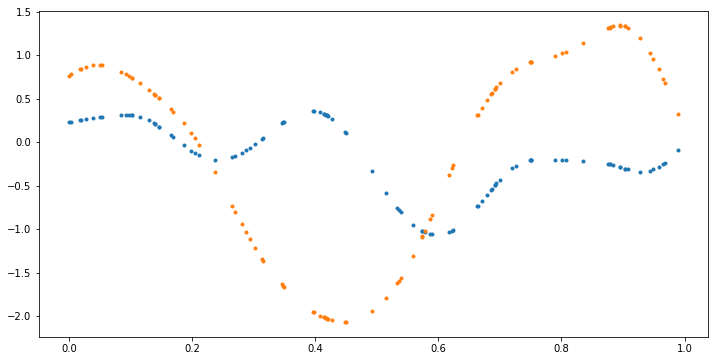

In [10]:
"""
X = np.vstack([np.random.randn(10,2) + [2,2],
               np.random.randn(10,2) + [-2,2],
               np.random.randn(10,2) + [2,-2]])
Y = np.repeat(np.eye(3), 10, 0)

print(X.shape)
"""
#make a one dimensional classification problem
np.random.seed(1)
X = np.random.rand(100,1)
K = np.exp(-0.5*np.square(X - X.T)/0.01) + np.eye(100)*1e-6
f = np.dot(np.linalg.cholesky(K), np.random.randn(100,2))
Y = np.array(np.argmax(f, 1).reshape(-1,1), dtype=float)

plt.figure(figsize=(12,6))
plt.plot(X, f, '.');
"""
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
plt.scatter(X[:,0], X[:,1], 100, np.argmax(Y, 1), lw=2, cmap=plt.cm.viridis)
"""

# Training. Based on GPflow examples

In [11]:
gpflow.reset_default_graph_and_session()

In [12]:
with gpflow.defer_build():
    kernel = GP2MLP(input_dim=1, w=np.random.multivariate_normal([0.,0.,0.],3.*np.identity(3),size=1), N=3, bias=0.0) 
    l = gpflow.likelihoods.MultiClass(2)
    m = gpflow.models.SGPMC(X, Y, kern=kernel, likelihood=l ,Z=X[::5].copy(),num_latent=2)
    m.kern.variances.prior = gpflow.priors.Gaussian(0.,3.)
    m.kern.biases.prior = gpflow.priors.Gaussian(0.,1.)
    
m.likelihood.invlink.epsilon.set_trainable(True)
m.feature.trainable = True

In [13]:
m.compile()    
m.as_pandas_table()

1
1
2


,class,prior,transform,trainable,shape,fixed_shape,value
SGPMC/V,Parameter,"N([ 0.],[ 1.])",(none),True,"(20, 2)",True,"[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0..."
SGPMC/feature/Z,Parameter,None,(none),True,"(20, 1)",True,"[[0.417022004703], [0.0923385947688], [0.41919..."
SGPMC/kern/variances,Parameter,"N([ 0.],[ 3.])",+ve,True,"(1, 3)",True,"[[-1.51949616331, -1.50305156018, -2.495670481..."
SGPMC/kern/biases,Parameter,"N([ 0.],[ 1.])",(none),True,(),True,0.0
SGPMC/likelihood/invlink/epsilon,Parameter,"Beta([ 0.2],[ 5.])","[0.0, 1.0]",True,(),True,0.001


In [14]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m, maxiter=notebook_niter(1000))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 195.559042
  Number of iterations: 28
  Number of functions evaluations: 74


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 195.559042
  Number of iterations: 28
  Number of functions evaluations: 74


In [15]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SGPMC/V,Parameter,"N([ 0.],[ 1.])",(none),True,"(20, 2)",True,"[[-0.000492738956684, 0.000492738956684], [0.0..."
SGPMC/feature/Z,Parameter,None,(none),True,"(20, 1)",True,"[[0.417021906291], [0.0923385276315], [0.41919..."
SGPMC/kern/variances,Parameter,"N([ 0.],[ 3.])",+ve,True,"(1, 3)",True,"[[1.00000420242e-06, 1.00000420242e-06, 1.0000..."
SGPMC/kern/biases,Parameter,"N([ 0.],[ 1.])",(none),True,(),True,-4.130295942693851
SGPMC/likelihood/invlink/epsilon,Parameter,"Beta([ 0.2],[ 5.])","[0.0, 1.0]",True,(),True,0.2794076803941835


In [16]:
num_classes = 2
def plot(m):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    mu, var = m.predict_f(xx)
    mu, var = mu.copy(), var.copy()
    p, _ = m.predict_y(xx)
    
    a3.set_xticks([])
    a3.set_yticks([])
    
    for i in range(num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten()==i]
        points, = a3.plot(x, x*0, '.')
        color=points.get_color()
        a1.plot(xx, mu[:,i], color=color, lw=2)
        a1.plot(xx, mu[:,i] + 2*np.sqrt(var[:,i]), '--', color=color)
        a1.plot(xx, mu[:,i] - 2*np.sqrt(var[:,i]), '--', color=color)
        a2.plot(xx, p[:,i], '-', color=color, lw=2)
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])

1
1
2
1
1
2


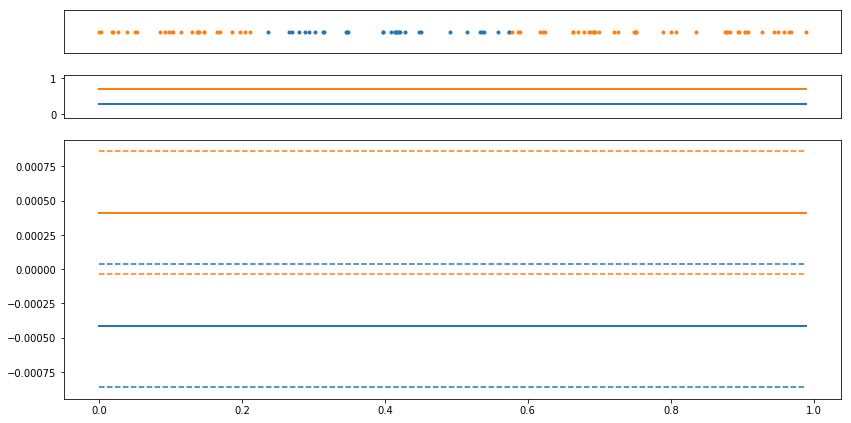

In [17]:
plot(m)

# Plotting tools for MCMC training

In [18]:

num_classes = 2
def plot_from_samples(m, samples):
    f = plt.figure(figsize=(12,6))
    a1 = f.add_axes([0.05, 0.05, 0.9, 0.6])
    a2 = f.add_axes([0.05, 0.7, 0.9, 0.1])
    a3 = f.add_axes([0.05, 0.85, 0.9, 0.1])
    
    xx = np.linspace(m.X.read_value().min(), m.X.read_value().max(), 200).reshape(-1,1)
    
    Fpred, Ypred = [], []

    for i, s in samples[burn::thin].iterrows():  # also possible as arguments to hmc.sample()
        feed_dict = m.sample_feed_dict(s)
        Ypred.append(m.predict_y(xx, feed_dict=feed_dict)[0])
        Fpred.append(m.predict_f_samples(xx, 1, feed_dict=feed_dict).squeeze())

    print(Fpred[0].shape)
    for i in range(num_classes):
        x = m.X.read_value()[m.Y.read_value().flatten() == i]
        points, = a3.plot(x, x*0, '.')  # ground truth
        color = points.get_color()
        for F in Fpred:
            a1.plot(xx, F[:,i], color=color, lw=0.2, alpha=1.0)  # squashed values
        for Y in Ypred:
            #print(Y)
            a2.plot(xx, Y[:,i], color=color, lw=0.5, alpha=1.0) #prediction
    
    a2.set_ylim(-0.1, 1.1)
    a2.set_yticks([0, 1])
    a2.set_xticks([])
        
    a3.set_xticks([])
    a3.set_yticks([])
    

if is_continuous_integration():
    burn = 0
    thin = 1
else:
    burn = 100
    thin = 10
    
hmc = gpflow.train.HMC()
samples = hmc.sample(m, num_samples=notebook_niter(2000), epsilon=0.04, lmax=15, logprobs=False)


1
1
2
1
1
2
1
1
2


1
1
1
(200, 2)


,SGPMC/V,SGPMC/feature/Z,SGPMC/kern/biases,SGPMC/kern/variances,SGPMC/likelihood/invlink/epsilon
0,"[[-0.000492738956684, 0.000492738956684], [0.0...","[[0.417021906291], [0.0923385276315], [0.41919...",-4.130296,"[[1.00000420242e-06, 1.00000420242e-06, 1.0000...",0.279408
1,"[[-0.000492738956684, 0.000492738956684], [0.0...","[[0.417021906291], [0.0923385276315], [0.41919...",-4.130296,"[[1.00000420242e-06, 1.00000420242e-06, 1.0000...",0.279408
2,"[[-0.000492738956684, 0.000492738956684], [0.0...","[[0.417021906291], [0.0923385276315], [0.41919...",-4.130296,"[[1.00000420242e-06, 1.00000420242e-06, 1.0000...",0.279408
3,"[[-0.000492738956684, 0.000492738956684], [0.0...","[[0.417021906291], [0.0923385276315], [0.41919...",-4.130296,"[[1.00000420242e-06, 1.00000420242e-06, 1.0000...",0.279408
4,"[[-0.000492738956684, 0.000492738956684], [0.0...","[[0.417021906291], [0.0923385276315], [0.41919...",-4.130296,"[[1.00000420242e-06, 1.00000420242e-06, 1.0000...",0.279408


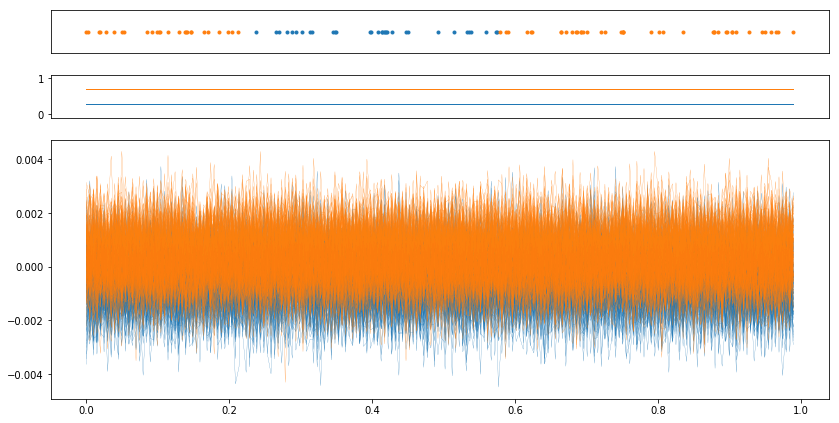

In [19]:

plot_from_samples(m, samples)
samples.head()
